<a href="https://colab.research.google.com/github/Marcin19721205/Wprowadzenie-Do-Sieci-Neuronowych/blob/main/16_Keras08_housing_prices_regression02MJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Regresja - NN sekwencyjna z regularyzacją i dropout, zapisujaca wyniki tuningu




### <a name='a0'></a> 1. Import biblotek

In [1]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import gc #garbage collector - usuwa dane, co do których nie ma odniesien w kodzie
import tensorflow as tf
import sklearn.datasets as skds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=12, suppress=True, linewidth=150)
pd.options.display.float_format = '{:.6f}'.format
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.19.0'

### <a name='a1'></a> 2. Załadowanie danych i wstępna eksploracja

Zapis do dataset_raw  

In [2]:
raw_dataset = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ann-course/housing.csv')
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Kopia danych surowych do dataset uzywany w kodzie

In [3]:
dataset = raw_dataset.copy()
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,NEAR BAY
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,NEAR BAY
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,NEAR BAY
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,NEAR BAY
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,NEAR BAY


In [4]:
dataset.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.090000,39.480000,25.000000,1665.000000,374.000000,845.000000,330.000000,1.560300,78100.000000,INLAND
20636,-121.210000,39.490000,18.000000,697.000000,150.000000,356.000000,114.000000,2.556800,77100.000000,INLAND
20637,-121.220000,39.430000,17.000000,2254.000000,485.000000,1007.000000,433.000000,1.700000,92300.000000,INLAND
20638,-121.320000,39.430000,18.000000,1860.000000,409.000000,741.000000,349.000000,1.867200,84700.000000,INLAND
20639,-121.240000,39.370000,16.000000,2785.000000,616.000000,1387.000000,530.000000,2.388600,89400.000000,INLAND


Sprawdzenie brakujących wartości

In [5]:
dataset.isnull().sum() / len(dataset)

,0
longitude,0.000000
latitude,0.000000
housing_median_age,0.000000
total_rooms,0.000000
total_bedrooms,0.010029
population,0.000000
households,0.000000
median_income,0.000000
median_house_value,0.000000
ocean_proximity,0.000000


Usuniecie rekordów z brakami

In [6]:
dataset.dropna(inplace=True) #usun rekordy, gdzie są NaN

dataset.isnull().sum() / len(dataset)

,0
longitude,0.000000
latitude,0.000000
housing_median_age,0.000000
total_rooms,0.000000
total_bedrooms,0.000000
population,0.000000
households,0.000000
median_income,0.000000
median_house_value,0.000000
ocean_proximity,0.000000


Statystyki dataset - numeryczne

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20433.000000,-119.570689,2.003578,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20433.000000,35.633221,2.136348,32.540000,33.930000,34.260000,37.720000,41.950000
housing_median_age,20433.000000,28.633094,12.591805,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20433.000000,2636.504233,2185.269567,2.000000,1450.000000,2127.000000,3143.000000,39320.000000
total_bedrooms,20433.000000,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20433.000000,1424.946949,1133.208490,3.000000,787.000000,1166.000000,1722.000000,35682.000000
households,20433.000000,499.433465,382.299226,1.000000,280.000000,409.000000,604.000000,6082.000000
median_income,20433.000000,3.871162,1.899291,0.499900,2.563700,3.536500,4.744000,15.000100
median_house_value,20433.000000,206864.413155,115435.667099,14999.000000,119500.000000,179700.000000,264700.000000,500001.000000


Statystyki dataset - obiektowe

In [8]:
dataset.describe(include=['object']).T

,count,unique,top,freq
ocean_proximity,20433,5,<1H OCEAN,9034


Oblicz ilość wystąpień w klasie 'category'

In [9]:
dataset.ocean_proximity.value_counts()

,count
ocean_proximity,
<1H OCEAN,9034
INLAND,6496
NEAR OCEAN,2628
NEAR BAY,2270
ISLAND,5


Histogram Zmiennej Docelowej

In [10]:
px.histogram(dataset, x='median_house_value')
#px.histogram(dataset, x='median_income') #skośny

Ilość wystąpień zmiennej docelowej

In [11]:
dataset.median_house_value.value_counts()

,count
median_house_value,
500001.000000,958
137500.000000,119
162500.000000,116
112500.000000,103
187500.000000,92
...,...
397400.000000,1
492000.000000,1
476300.000000,1


Wartość 500001 jest niewiarygodna, jest to ucięta do tej wartości cena z inneg przedziału.

odrzucamy te wystąpienia

In [12]:
index_to_drop = dataset[dataset.median_house_value == 500001].index
dataset = dataset.drop(index=index_to_drop)
px.histogram(dataset, x='median_house_value')

Get dummies - do zakodowania danych kategorycznych, z drop first = True (pomin pierwsze)

In [13]:
dataset_dummies = pd.get_dummies(dataset, drop_first=True)
dataset_dummies = dataset_dummies.astype({col: float for col in dataset_dummies.select_dtypes('bool').columns}) #bez tego bool są true/false a teraz 0 i 1 - przy standaryzacji nie będzie błedów

dataset_dummies.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,0.000000,0.000000,1.000000,0.000000
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,0.000000,0.000000,1.000000,0.000000
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,0.000000,0.000000,1.000000,0.000000
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,0.000000,0.000000,1.000000,0.000000
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,0.000000,0.000000,1.000000,0.000000


### <a name='a2'></a> 3. Podział na zbiór treningowy oraz testowy

In [14]:
train_dataset = dataset_dummies.sample(frac=0.8, random_state=0)
test_dataset = dataset_dummies.drop(train_dataset.index)

print(f'train_dataset length: {len(train_dataset)}')
print(f'test_dataset length: {len(test_dataset)}')

train_dataset length: 15580
test_dataset length: 3895


In [15]:
train_dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19234,-122.690000,38.510000,18.000000,3364.000000,501.000000,1442.000000,506.000000,6.685400,313000.000000,0.000000,0.000000,0.000000,0.000000
1859,-124.140000,41.950000,21.000000,2696.000000,578.000000,1208.000000,494.000000,2.275000,122400.000000,0.000000,0.000000,0.000000,1.000000
51,-122.270000,37.820000,43.000000,1868.000000,456.000000,1061.000000,407.000000,1.504500,93800.000000,0.000000,0.000000,1.000000,0.000000
11192,-117.930000,33.820000,28.000000,2444.000000,555.000000,1848.000000,567.000000,3.017900,198800.000000,0.000000,0.000000,0.000000,0.000000
20355,-118.960000,34.190000,16.000000,1807.000000,346.000000,587.000000,296.000000,1.981100,162500.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
test_dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
10,-122.260000,37.850000,52.000000,2202.000000,434.000000,910.000000,402.000000,3.203100,281500.000000,0.000000,0.000000,1.000000,0.000000
13,-122.260000,37.840000,52.000000,696.000000,191.000000,345.000000,174.000000,2.673600,191300.000000,0.000000,0.000000,1.000000,0.000000
19,-122.270000,37.840000,52.000000,1503.000000,298.000000,690.000000,275.000000,2.603300,162900.000000,0.000000,0.000000,1.000000,0.000000
26,-122.280000,37.850000,49.000000,1130.000000,244.000000,607.000000,239.000000,2.459700,93800.000000,0.000000,0.000000,1.000000,0.000000
40,-122.260000,37.830000,52.000000,1665.000000,419.000000,946.000000,395.000000,2.097800,155400.000000,0.000000,0.000000,1.000000,0.000000


Relacje pomiedzy poszczególnymi zmiennymi

In [16]:
px.scatter_matrix(train_dataset, dimensions=['median_house_value', 'housing_median_age', 'median_income', 'total_rooms'], color='median_house_value', height=700)

Staystyki zbioru treningowego do standaryzacji

In [17]:
train_stats = train_dataset.describe() #wpisuje do train_stat statystyki opisowe train_dataset.describe()
train_stats.pop('median_house_value') #usuwam label ze statystyk
train_stats = train_stats.transpose() #przedstawiam jako transponowane
train_stats

,count,mean,std,min,25%,50%,75%,max
longitude,15580.000000,-119.558780,2.006237,-124.350000,-121.750000,-118.490000,-117.990000,-114.470000
latitude,15580.000000,35.648614,2.147016,32.550000,33.930000,34.270000,37.730000,41.950000
housing_median_age,15580.000000,28.489217,12.505895,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,15580.000000,2620.014506,2195.654212,2.000000,1441.000000,2112.000000,3119.000000,39320.000000
total_bedrooms,15580.000000,539.900578,424.499548,2.000000,299.000000,436.000000,647.000000,6445.000000
population,15580.000000,1441.193068,1160.542775,3.000000,801.000000,1179.000000,1746.000000,35682.000000
households,15580.000000,501.099487,385.039835,2.000000,283.000000,411.000000,605.000000,6082.000000
median_income,15580.000000,3.672427,1.570297,0.499900,2.519975,3.440500,4.581425,15.000100
ocean_proximity_INLAND,15580.000000,0.333569,0.471503,0.000000,0.000000,0.000000,1.000000,1.000000
ocean_proximity_ISLAND,15580.000000,0.000193,0.013876,0.000000,0.000000,0.000000,0.000000,1.000000


#Wyrywamy labele - targety z danych

In [18]:
train_labels = train_dataset.pop('median_house_value') #wez labele train dataset
test_labels = test_dataset.pop('median_house_value') #as above

### <a name='a3'></a> 4. Standaryzacja danych
# średnia i Sx są liczone na zbiorze treningowym, ale stosowane na treningowym i testowym

Normalizacja danych

In [19]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [20]:
normed_train_data = norm(train_dataset) #znormalizuj dane
normed_test_data = norm(test_dataset) #znormalizuj dane

In [21]:
normed_train_data.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity_INLAND,0
ocean_proximity_ISLAND,0


In [22]:
normed_train_data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19234,-1.560743,1.332727,-0.838742,0.338845,-0.091639,0.000695,0.012727,1.918729,-0.707459,-0.013877,-0.346133,-0.378230
1859,-2.283490,2.934950,-0.598855,0.034607,0.089751,-0.200934,-0.018438,-0.889913,-0.707459,-0.013877,-0.346133,2.643727
51,-1.351396,1.011351,1.160315,-0.342501,-0.197646,-0.327599,-0.244389,-1.380585,-0.707459,-0.013877,2.888874,-0.378230


In [23]:
normed_test_data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
10,-1.346412,1.025324,1.879976,-0.190383,-0.249472,-0.457711,-0.257375,-0.298878,-0.707459,-0.013877,2.888874,-0.378230
13,-1.346412,1.020666,1.879976,-0.876283,-0.821910,-0.944552,-0.849521,-0.636075,-0.707459,-0.013877,2.888874,-0.378230
19,-1.351396,1.020666,1.879976,-0.508739,-0.569849,-0.647277,-0.587211,-0.680844,-0.707459,-0.013877,2.888874,-0.378230


To wynika z Numpy

In [24]:
normed_test_data = normed_test_data.values
normed_train_data = normed_train_data.values

### <a name='a4'></a> 5. Budowa modelu

Model1

In [25]:
def build_model1():
    model1 = Sequential()
    model1.add(Dense(1024, kernel_regularizer='l2', activation='relu', input_shape=[len(train_dataset.keys())]))
    model1.add(Dense(512, activation='relu'))
    model1.add(Dense(128, activation='relu'))
    model1.add(Dense(1)) #model regresyjny, na wyjściowej nie dajemy funkcji aktywacji



    model1.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model1

In [26]:
model1 = build_model1()
model1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,905 (2.30 MB)

 Trainable params: 603,905 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

### <a name='a5'></a> 6. Trenowanie sieci

In [27]:
history1 = model1.fit(normed_train_data, train_labels.values, epochs=150, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 30714750976.0000 - mae: 142322.7500 - mse: 30714750976.0000 - val_loss: 4560218112.0000 - val_mae: 48816.3555 - val_mse: 4560218112.0000
Epoch 2/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4472470016.0000 - mae: 48031.9609 - mse: 4472470016.0000 - val_loss: 3790806272.0000 - val_mae: 45190.1875 - val_mse: 3790806272.0000
Epoch 3/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3725006336.0000 - mae: 43863.1445 - mse: 3725006336.0000 - val_loss: 3582025728.0000 - val_mae: 43791.5469 - val_mse: 3582025728.0000
Epoch 4/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3600615680.0000 - mae: 43436.7188 - mse: 3600615680.0000 - val_loss: 3486482944.0000 - val_mae: 42943.7188 - val_mse: 3486482944.0000
Epoch 5/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3634414848.0000 - mae: 43075.8203 - mse: 3634414848.0000 - val_loss: 3438009856.0000 - val_mae: 42842.2578 - val_mse: 3438009856.0000
Epoch 6/150
390/390 ━

Po analizie widac, że można by dać regularyzacje

In [29]:
def plot_hist(history1):
    hist = pd.DataFrame(history1.history)
    hist['epoch'] = history1.epoch
    hist['rmse'] = np.sqrt(hist['mse'])
    hist['val_rmse'] = np.sqrt(hist['val_mse'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['mae'], name='mae', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_mae'], name='val_mae', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='MAE vs. VAL_MAE', xaxis_title='Epoki', yaxis_title='Mean Absolute Error', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['rmse'], name='rmse', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_rmse'], name='val_rmse', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='RMSE vs. VAL_RMSE', xaxis_title='Epoki', yaxis_title='Root Mean Squared Error', yaxis_type='log')
    fig.show()

plot_hist(history1)

Metryka na zbiorze testowym

Porównać należy mae z testowego z mae z treningowego

In [30]:
for name, value in zip(model1.metrics_names, model1.evaluate(normed_test_data, test_labels.values)):
    print(f'{name:8}{value:.4f}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2222435072.0000 - mae: 33093.3164 - mse: 2222435072.0000
loss    2320685568.0000
compile_metrics34106.5898


predict tagert na danych testowych

In [31]:
test_predictions = model1.predict(normed_test_data).flatten()
test_predictions

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([201031.89, 169213.48, 146501.34, ...,  89592.03, 131913.88,  68016.95], dtype=float32)

In [34]:
pred1 = pd.DataFrame(test_labels)
pred1['predictions'] = test_predictions
pred1.head()

,median_house_value,predictions
10,281500.000000,201031.890625
13,191300.000000,169213.484375
19,162900.000000,146501.343750
26,93800.000000,121351.820312
40,155400.000000,153953.843750


Wykres Q-Q

In [35]:
fig = px.scatter(pred1, 'median_house_value', 'predictions')
fig.add_trace(go.Scatter(x=[0, 500000], y=[0, 500000], mode='lines'))
fig.show()

In [36]:
pred1.head()

,median_house_value,predictions
10,281500.000000,201031.890625
13,191300.000000,169213.484375
19,162900.000000,146501.343750
26,93800.000000,121351.820312
40,155400.000000,153953.843750


In [38]:
pred1['error'] = pred1['median_house_value'] - pred1['predictions']
pred1.head()

,median_house_value,predictions,error
10,281500.000000,201031.890625,80468.109375
13,191300.000000,169213.484375,22086.515625
19,162900.000000,146501.343750,16398.656250
26,93800.000000,121351.820312,-27551.820312
40,155400.000000,153953.843750,1446.156250


In [39]:
px.histogram(pred1, 'error', marginal='rug', width=1000)

MODEL 2 - regularyzacja L2

In [42]:
from tensorflow.keras import regularizers

def build_model2():
    model2 = Sequential()

    # Każda warstwa ma L2 regularizację
    model2.add(Dense(1024, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=[len(train_dataset.keys())]))

    model2.add(Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)))

    model2.add(Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)))

    # Wyjście modelu regresyjnego (bez aktywacji)
    model2.add(Dense(1))

    model2.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model2


In [43]:
model2 = build_model1()
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1024)           │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,905 (2.30 MB)

 Trainable params: 603,905 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history2 = model2.fit(normed_train_data, train_labels.values, epochs=150, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 30610987008.0000 - mae: 141984.3594 - mse: 30610987008.0000 - val_loss: 4591907840.0000 - val_mae: 49406.0039 - val_mse: 4591907840.0000
Epoch 2/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4345819136.0000 - mae: 47176.7070 - mse: 4345819136.0000 - val_loss: 3764305152.0000 - val_mae: 44857.2617 - val_mse: 3764305152.0000
Epoch 3/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3705686528.0000 - mae: 43864.6797 - mse: 3705686528.0000 - val_loss: 3640461824.0000 - val_mae: 44865.0234 - val_mse: 3640461824.0000
Epoch 4/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3608899328.0000 - mae: 43188.5664 - mse: 3608899328.0000 - val_loss: 3475638016.0000 - val_mae: 42477.7773 - val_mse: 3475638016.0000
Epoch 5/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3509465088.0000 - mae: 42557.6367 - mse: 3509465088.0000 - val_loss: 3470837248.0000 - val_mae: 43525.3906 - val_mse: 3470837248.0000
Epoch 6/150
390/390 ━━

In [46]:
def plot_hist(history2):
    hist = pd.DataFrame(history2.history)
    hist['epoch'] = history2.epoch
    hist['rmse'] = np.sqrt(hist['mse'])
    hist['val_rmse'] = np.sqrt(hist['val_mse'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['mae'], name='mae', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_mae'], name='val_mae', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='MAE vs. VAL_MAE', xaxis_title='Epoki', yaxis_title='Mean Absolute Error', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['rmse'], name='rmse', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_rmse'], name='val_rmse', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='RMSE vs. VAL_RMSE', xaxis_title='Epoki', yaxis_title='Root Mean Squared Error', yaxis_type='log')
    fig.show()

plot_hist(history2)

In [47]:
for name, value in zip(model2.metrics_names, model2.evaluate(normed_test_data, test_labels.values)):
    print(f'{name:8}{value:.4f}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2221499136.0000 - mae: 32151.2930 - mse: 2221499136.0000
loss    2343964672.0000
compile_metrics32710.4219


In [48]:
test_predictions2 = model2.predict(normed_test_data).flatten()
test_predictions2

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([235693.94 , 198333.69 , 181709.34 , ...,  83745.13 , 132244.28 ,  71848.375], dtype=float32)

In [49]:
pred2 = pd.DataFrame(test_labels)
pred2['predictions'] = test_predictions2
pred2.head()

,median_house_value,predictions
10,281500.000000,235693.937500
13,191300.000000,198333.687500
19,162900.000000,181709.343750
26,93800.000000,152737.625000
40,155400.000000,174669.343750


In [50]:
fig = px.scatter(pred2, 'median_house_value', 'predictions')
fig.add_trace(go.Scatter(x=[0, 500000], y=[0, 500000], mode='lines'))
fig.show()

In [51]:
pred2['error'] = pred2['median_house_value'] - pred2['predictions']
pred2.head()

,median_house_value,predictions,error
10,281500.000000,235693.937500,45806.062500
13,191300.000000,198333.687500,-7033.687500
19,162900.000000,181709.343750,-18809.343750
26,93800.000000,152737.625000,-58937.625000
40,155400.000000,174669.343750,-19269.343750


In [52]:
px.histogram(pred2, 'error', marginal='rug', width=1000)

MODEL 3

In [53]:

def build_model3():
    model3 = Sequential()

    # Każda warstwa ma L2 regularizację
    model3.add(Dense(1024, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001),
                     input_shape=[len(train_dataset.keys())]))

    model3.add(Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001)))

    model3.add(Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001)))

    # Wyjście modelu regresyjnego (bez aktywacji)
    model3.add(Dense(1))

    model3.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model3

In [54]:
model3 = build_model3()
model3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1024)           │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,905 (2.30 MB)

 Trainable params: 603,905 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history3 = model3.fit(normed_train_data, train_labels.values, epochs=150, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 31346276352.0000 - mae: 143025.9688 - mse: 31292897280.0000 - val_loss: 4879315968.0000 - val_mae: 50103.3008 - val_mse: 4707795456.0000
Epoch 2/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4545716736.0000 - mae: 47643.7891 - mse: 4382359552.0000 - val_loss: 3963057920.0000 - val_mae: 45253.7188 - val_mse: 3803928576.0000
Epoch 3/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4036374784.0000 - mae: 44678.7656 - mse: 3882711296.0000 - val_loss: 3754880768.0000 - val_mae: 43389.5625 - val_mse: 3611341056.0000
Epoch 4/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3773519616.0000 - mae: 43629.6523 - mse: 3632165632.0000 - val_loss: 3676465920.0000 - val_mae: 43892.4570 - val_mse: 3535359232.0000
Epoch 5/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3617176832.0000 - mae: 42506.4180 - mse: 3483569664.0000 - val_loss: 3557985024.0000 - val_mae: 42816.2148 - val_mse: 3430927104.0000
Epoch 6/150
390/390 ━

In [56]:
plot_hist(history3)

In [57]:
for name, value in zip(model3.metrics_names, model3.evaluate(normed_test_data, test_labels.values)):
    print(f'{name:8}{value:.4f}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2093121792.0000 - mae: 31248.1309 - mse: 2085291392.0000
loss    2193396992.0000
compile_metrics32250.7949


In [58]:
test_predictions3 = model3.predict(normed_test_data).flatten()
pred3 = pd.DataFrame(test_labels)
pred3['predictions'] = test_predictions3
pred3['error'] = pred3['median_house_value'] - pred3['predictions']

display(pred3.head())
px.scatter(pred3, 'median_house_value', 'predictions').add_trace(go.Scatter(x=[0, 500000], y=[0, 500000], mode='lines')).show()
px.histogram(pred3, 'error', marginal='rug', width=1000).show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,median_house_value,predictions,error
10,281500.000000,201938.171875,79561.828125
13,191300.000000,178105.343750,13194.656250
19,162900.000000,153190.250000,9709.750000
26,93800.000000,131303.656250,-37503.656250
40,155400.000000,157788.781250,-2388.781250


Model 4 - z dropout

In [61]:
def build_model4():
    model4 = Sequential()

    # Każda warstwa ma L2 regularizację i dropout
    model4.add(Dense(1024, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001),
                     input_shape=[len(train_dataset.keys())]))

    model4.add(Dropout(0.2))

    model4.add(Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001)))

    model4.add(Dropout(0.2))

    model4.add(Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     bias_regularizer=regularizers.l2(0.001),
                     activity_regularizer=regularizers.l2(0.001)))

    model4.add(Dropout(0.2))

    # Wyjście modelu regresyjnego (bez aktywacji)
    model4.add(Dense(1))

    model4.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model4

In [62]:
model4 = build_model4()
model4.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1024)           │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,905 (2.30 MB)

 Trainable params: 603,905 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history4 = model3.fit(normed_train_data, train_labels.values, epochs=150, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1926237952.0000 - mae: 30488.2422 - mse: 1918103552.0000 - val_loss: 2294436864.0000 - val_mae: 33112.4688 - val_mse: 2286511872.0000
Epoch 2/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1862588032.0000 - mae: 29990.1152 - mse: 1854580864.0000 - val_loss: 2390224128.0000 - val_mae: 33337.5898 - val_mse: 2382743296.0000
Epoch 3/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1867640576.0000 - mae: 30020.9102 - mse: 1859726080.0000 - val_loss: 2306824192.0000 - val_mae: 33098.4531 - val_mse: 2298819072.0000
Epoch 4/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1835494912.0000 - mae: 29805.0078 - mse: 1827628160.0000 - val_loss: 2370811904.0000 - val_mae: 33272.4023 - val_mse: 2363483648.0000
Epoch 5/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1921021568.0000 - mae: 30141.3027 - mse: 1913203968.0000 - val_loss: 2363053312.0000 - val_mae: 32781.2266 - val_mse: 2356023040.0000
Epoch 6/150
390/390 ━━━━━

In [64]:
plot_hist(history4)

In [65]:
for name, value in zip(model4.metrics_names, model4.evaluate(normed_test_data, test_labels.values)):
    print(f'{name:8}{value:.4f}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 44308156416.0000 - mae: 187575.8594 - mse: 44308156416.0000
loss    46619160576.0000
compile_metrics193120.3750


In [66]:
test_predictions4 = model4.predict(normed_test_data).flatten()
pred4 = pd.DataFrame(test_labels)
pred4['predictions'] = test_predictions3
pred4['error'] = pred4['median_house_value'] - pred4['predictions']

display(pred4.head())
px.scatter(pred4, 'median_house_value', 'predictions').add_trace(go.Scatter(x=[0, 500000], y=[0, 500000], mode='lines')).show()
px.histogram(pred4, 'error', marginal='rug', width=1000).show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,median_house_value,predictions,error
10,281500.000000,201938.171875,79561.828125
13,191300.000000,178105.343750,13194.656250
19,162900.000000,153190.250000,9709.750000
26,93800.000000,131303.656250,-37503.656250
40,155400.000000,157788.781250,-2388.781250


                    Model          MAE               MSE
3  Model 4 (L2 + Dropout) 26874.767578 1493730304.000000
2       Model 3 (Dropout) 30181.568359 1886219776.000000
1            Model 2 (L2) 31153.882812 2013850624.000000
0                 Model 1 31342.595703 2025042176.000000


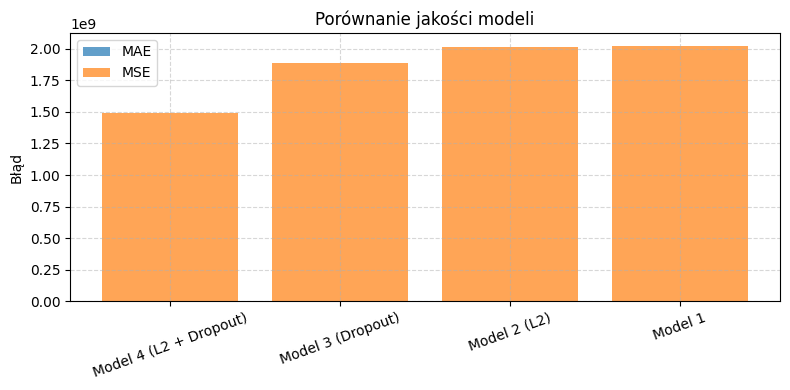

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1️⃣ Zbierz wyniki (MAE i MSE) ===
results = pd.DataFrame({
    'Model': ['Model 1', 'Model 2 (L2)', 'Model 3 (Dropout)', 'Model 4 (L2 + Dropout)'],
    'MAE': [
        history1.history['mae'][-1],
        history2.history['mae'][-1],
        history3.history['mae'][-1],
        history4.history['mae'][-1]
    ],
    'MSE': [
        history1.history['mse'][-1],
        history2.history['mse'][-1],
        history3.history['mse'][-1],
        history4.history['mse'][-1]
    ]
})

# === 2️⃣ Posortuj po MAE (mniejsze = lepsze) ===
results = results.sort_values('MAE')
print(results)

# === 3️⃣ Wykres porównawczy ===
plt.figure(figsize=(8, 4))
plt.bar(results['Model'], results['MAE'], label='MAE', alpha=0.7)
plt.bar(results['Model'], results['MSE'], label='MSE', alpha=0.7)
plt.title('Porównanie jakości modeli')
plt.ylabel('Błąd')
plt.legend()
plt.xticks(rotation=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



=== PORÓWNANIE MODELI ===
                         Model          MAE               MSE
0             Model 1 - bazowy 31342.595703 2025042176.000000
1  Model 2 - L2 regularization 31153.882812 2013850624.000000
2            Model 3 - Dropout 30181.568359 1886219776.000000
3       Model 4 - L2 + Dropout 26874.767578 1493730304.000000


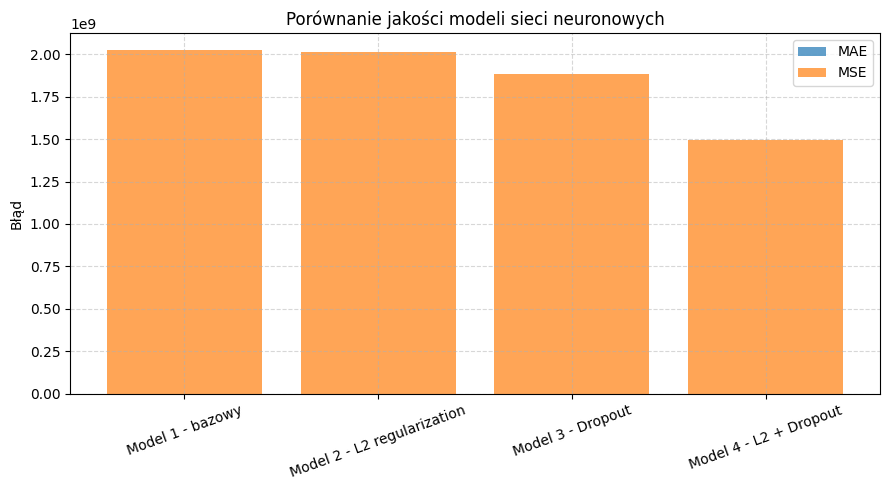

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Zbierz dane z historii uczenia ---
models = [
    'Model 1 - bazowy',
    'Model 2 - L2 regularization',
    'Model 3 - Dropout',
    'Model 4 - L2 + Dropout'
]

mae = [
    history1.history['mae'][-1],
    history2.history['mae'][-1],
    history3.history['mae'][-1],
    history4.history['mae'][-1]
]

mse = [
    history1.history['mse'][-1],
    history2.history['mse'][-1],
    history3.history['mse'][-1],
    history4.history['mse'][-1]
]

# --- Stwórz tabelę porównawczą ---
results = pd.DataFrame({
    'Model': models,
    'MAE': mae,
    'MSE': mse
})

print('\n=== PORÓWNANIE MODELI ===')
print(results)

# --- Wykres porównawczy ---
plt.figure(figsize=(9, 5))
plt.bar(results['Model'], results['MAE'], label='MAE', alpha=0.7)
plt.bar(results['Model'], results['MSE'], label='MSE', alpha=0.7)
plt.title('Porównanie jakości modeli sieci neuronowych')
plt.ylabel('Błąd')
plt.legend()
plt.xticks(rotation=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


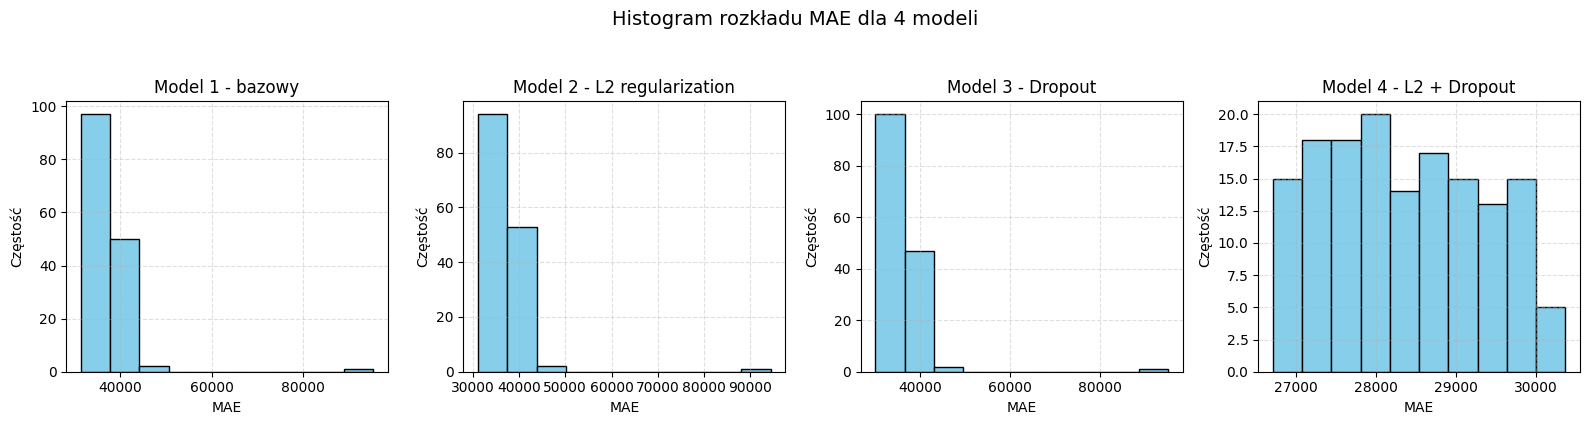

In [70]:
import matplotlib.pyplot as plt

# --- dane z historii (użyjemy błędu MAE z każdej epoki) ---
histories = [
    history1.history['mae'],
    history2.history['mae'],
    history3.history['mae'],
    history4.history['mae']
]

titles = [
    'Model 1 - bazowy',
    'Model 2 - L2 regularization',
    'Model 3 - Dropout',
    'Model 4 - L2 + Dropout'
]

# --- Rysowanie 4 histogramów obok siebie ---
plt.figure(figsize=(16, 4))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(histories[i], bins=10, color='skyblue', edgecolor='black')
    plt.title(titles[i])
    plt.xlabel('MAE')
    plt.ylabel('Częstość')
    plt.grid(True, linestyle='--', alpha=0.4)

plt.suptitle('Histogram rozkładu MAE dla 4 modeli', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


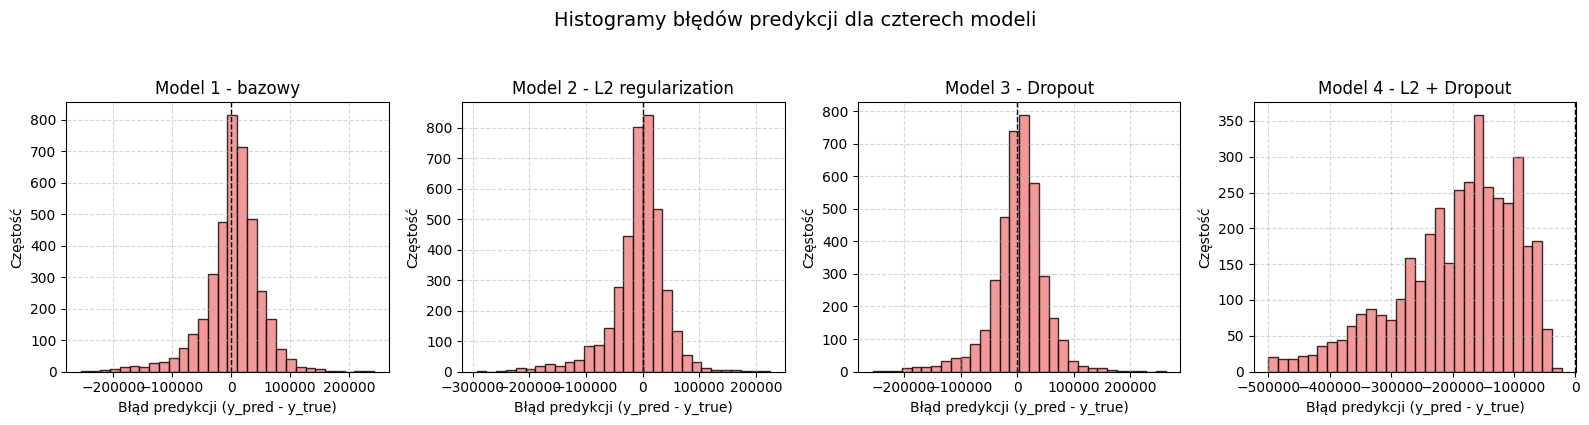

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# --- Predykcje dla danych testowych ---
pred1 = model1.predict(normed_test_data).flatten()
pred2 = model2.predict(normed_test_data).flatten()
pred3 = model3.predict(normed_test_data).flatten()
pred4 = model4.predict(normed_test_data).flatten()

# --- Błędy predykcji ---
error1 = pred1 - test_labels
error2 = pred2 - test_labels
error3 = pred3 - test_labels
error4 = pred4 - test_labels

# --- Listy do iteracji ---
errors = [error1, error2, error3, error4]
titles = [
    'Model 1 - bazowy',
    'Model 2 - L2 regularization',
    'Model 3 - Dropout',
    'Model 4 - L2 + Dropout'
]

# --- Rysowanie 4 histogramów obok siebie ---
plt.figure(figsize=(16, 4))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.hist(errors[i], bins=30, color='lightcoral', edgecolor='black', alpha=0.8)
    plt.title(titles[i])
    plt.xlabel('Błąd predykcji (y_pred - y_true)')
    plt.ylabel('Częstość')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.suptitle('Histogramy błędów predykcji dla czterech modeli', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()